In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from toolsets.ff_droup import process_mzml, feature_finding
from toolsets.search import quick_search_values, quick_search_sorted, string_search

In [3]:

import os
import pandas as pd
import numpy as np
import toolsets.ff_droup as ff
from tqdm import tqdm
import toolsets.spectra_operations as so
master_dir = '/Volumes/Natural Product Chemistry/Working Space/Fanzhou/Glocyside_library'
mzml_dir = os.path.join(master_dir, 'mzml')
features_dir = os.path.join(master_dir, 'features')
if os.path.exists(features_dir) == False:
    os.mkdir(features_dir)
for root, dirs, files in os.walk(mzml_dir):
    for file in tqdm(files):
        if file.endswith('.mzML'):
            try:
                ms1, ms2 =ff.process_mzml(os.path.join(mzml_dir, file), if_mix=False, rt_max=12)
                features_temp = ff.feature_finding(ms1, ms2)
                features_temp.to_csv(os.path.join(features_dir, file.split('.')[0]+'.csv'), index = False)
            except:
                print('this file is worng: ', file)

100%|██████████| 22/22 [24:46<00:00, 67.55s/it]


In [4]:
std_list = pd.read_csv(os.path.join(master_dir, 'Glycosides_LCMS_Librarytemplate.csv'))

In [5]:
reference_pmz = []
reference_mix = []
reference_rt = []
matched = pd.DataFrame()
for index, row in tqdm(std_list.iterrows(), total= len(std_list)):
    if len(row['RT'].split(','))==1:
        try:
            feature_all = pd.read_csv(os.path.join(features_dir, row['mix']+'.csv'))
        except:
            print('this mix is wrong')
            break
        feature_temp = quick_search_values(feature_all, 'precursor_mz', float(row['pmz'])-0.003, float(row['pmz'])+0.003, ifsorted=False)
        feature_temp = quick_search_values(feature_temp, 'rt', float(row['RT'])-3/60, float(row['RT'])+3/60, ifsorted=False)
        feature_temp['rt_offset']=abs(feature_temp['rt_offset'])
        feature_temp.sort_values(by = 'rt_offset', ascending=True, inplace=True)
        feature_temp.insert(0, 'reference_name', np.repeat(row['mix'], len(feature_temp)))
        feature_temp.insert(1, 'reference_precursor_mz', np.repeat(row['pmz'], len(feature_temp)))
        feature_temp.insert(5, 'reference_rt', np.repeat(float(row['RT']), len(feature_temp)))
        matched = pd.concat([matched, pd.DataFrame([feature_temp.iloc[0]])], ignore_index = True)



        # break
    # pass
    # break


100%|██████████| 22/22 [00:32<00:00,  1.49s/it]


In [6]:
import toolsets.spectra_operations as so
def export_msp_simple_msp(data,output_location):
    entry = ''
    for index, row in tqdm(data.iterrows(), total = len(data)):
        entry = entry + 'Name: ' + row['reference_name'] + '\n'
        # entry = entry + 'InChIKey: ' + str(row['reference_inchikey']) + '\n'
        # entry = entry + 'SMILES: ' + str(row['reference_smiles']) + '\n'
        entry = entry + 'RETENTIONTIME: ' + str(row['rt']) + '\n'
        entry = entry +'Spectrum_type: '+'MS2'+ '\n'
        entry = entry + 'PrecursorMZ: ' + str(row['precursor_mz']) + '\n'
        # entry = entry + 'InChIKey: ' + str(row['reference_inchikey']) + '\n'
        # entry = entry + 'Formula: ' + row['reference_formula'] + '\n'
        # entry = entry + 'ExactMass: ' + str(row['reference_mono_mass']) + '\n'
        # entry = entry + 'Precursor_type: ' + row['reference_adduct'] + '\n'
        # if ifcollision_energy:
        #     entry = entry + 'Collision_enerty: ' + str(row['Collision_energy']) + '\n'
        # entry = entry + 'RETENTIONTIME: ' + str(row['retention_time_wa']) + '\n'
        # if row['reference_adduct'][-1]=='+':
            # charge = '1+'
            # ionmode = 'P'
        # else:
        #     ionmode = 'N'
        # entry = entry+'Ion_mode: '+ionmode+ '\n'
        entry = (entry + 'Comment: ' + 'ms1intensity'+'_'+str(row['peak_apex_intensity'])+ '\n')
        # entry = entry + 'Spectrum_entropy: ' +str((row['spectrum_entropy'])) + '\n'
        # entry = entry + 'Normalized_entropy: ' + str((row['normalized_entropy'])) + '\n'
        entry = entry + 'Num peaks: ' + str(so.num_peaks(row['peaks'])) + '\n'
        entry = entry + row['peaks']
        # entry = entry +str(row['count'])
        entry = entry + '\n'
        entry = entry + '\n'

    #open text file
    text_file = open(output_location, "w",encoding='utf-8')

    #write string to file
    text_file.write(entry)

    #close file
    text_file.close()

In [7]:
export_msp_simple_msp(matched, os.path.join(master_dir, 'glycoside_library.msp'))

100%|██████████| 15/15 [00:00<00:00, 11468.20it/s]


In [8]:
matched.to_csv(os.path.join(master_dir, 'glycoside_lib.csv'), index = False)

In [49]:
ms1, ms2 = process_mzml(mzml_path='IDRun_D-Glu_2', parent_dir=mzml_dir, if_mix=True, rt_max=10)

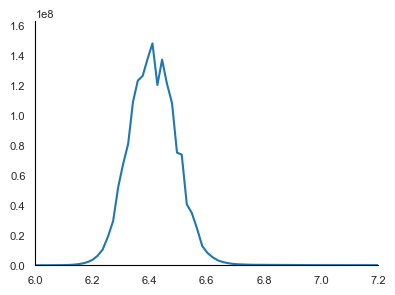

In [53]:
rt_list, intensity_list = ff.get_EIC_list(ms1, 447.125214)
ff.EIC(rt_list, intensity_list, rt_start=6, rt_end = 7.2)